<a href="https://colab.research.google.com/github/Leo-Lifeblood/Projects/blob/main/Autoencoder_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.3/515.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 40.6 MB/s eta 0:00:00
     ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/589.8 MB 212.4 MB/s eta 0:00:03

In [ ]:
import tensorflow as tf
import numpy as np
import keras_nlp as kn
from tqdm.notebook import tqdm

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
dataset_size = 200_000
#sequence_length = 128
#sequence_length = 16
sequence_length = 32
#upper_bound_integers = 10
upper_bound_integers = 60

In [ ]:
dataset = np.random.randint(0,upper_bound_integers,(dataset_size,sequence_length))

In [ ]:
dataset

array([[58, 48, 35, ...,  4, 46, 25],
       [24, 38, 43, ...,  8, 26, 39],
       [42, 14, 40, ..., 52, 53, 20],
       ...,
       [42, 11, 55, ...,  6, 47, 43],
       [58, 10, 24, ..., 44, 11,  1],
       [59, 58, 43, ..., 34, 46,  3]])

In [ ]:


class DenseGeGLU(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(DenseGeGLU, self).__init__(**kwargs)
        self.units = units
        self.dense = tf.keras.layers.Dense(self.units * 2)
        self.norm = tf.keras.layers.LayerNormalization()

    def call(self, inputs):
        x = self.dense(inputs)
        assert x.shape[-1] % 2 == 0
        x, gate = tf.split(x, num_or_size_splits=2, axis=-1)

        gate = tf.nn.gelu(gate)
        return self.norm(tf.multiply(x, gate))




class transformer_decoder_block(tf.keras.layers.Layer):
  def __init__(self, num_heads, key_dim):
    super().__init__()

    self.norm1 = tf.keras.layers.LayerNormalization()

    self.mha = tf.keras.layers.MultiHeadAttention(num_heads, key_dim)

    self.norm2 = tf.keras.layers.LayerNormalization()

    self.ff1 = tf.keras.layers.Dense(key_dim)
    self.ff2 = DenseGeGLU(key_dim*4)
    self.ff3 = tf.keras.layers.Dense(key_dim)

    self.norm3 = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.norm1(x)
    x2 = self.mha(x, x, use_causal_mask=True)
    x = self.norm2(x+x2)
    x2 = self.ff1(x)
    x2 = self.ff2(x2)
    x2 = self.ff3(x2)
    x = self.norm3(x+x2)

    return x

class baseline(tf.keras.Model):
  def __init__(self, vocab_size, num_heads, key_dim, num_layers):
    super().__init__()
    self.embeddings = kn.layers.ReversibleEmbedding(vocab_size, key_dim)

    self.rope = kn.layers.RotaryEmbedding()

    self.intermediate_layers = [transformer_decoder_block(num_heads, key_dim) for i in range(num_layers)]

  def call(self, x):

    x = self.embeddings(x)
    x = self.rope(x)

    for i in self.intermediate_layers:
      x = i(x)

    return self.embeddings(x, reverse=True)


In [ ]:
model = baseline(upper_bound_integers, 8, 128, 3)

In [ ]:
X = dataset[:,:-1]
Y = dataset[:,1:]

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
model.summary()

Model: "baseline_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reversible_embedding_13              │ ?                           │     0 (unbuilt) │
│ (ReversibleEmbedding)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rotary_embedding_13                  │ ?                           │               0 │
│ (RotaryEmbedding)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_block_33         │ ?                           │     0 (unbuilt) │
│ (transformer_decoder_block)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_block_34         │ ?                           │     0 (unbuilt) │
│ (transformer_decoder_block)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_block_35         │ ?                           │     0 (unbuilt) │
│ (transformer_decoder_block)          │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#Baseline

In [ ]:
baseline_history = model.fit(X,Y, epochs=15, batch_size=128)

Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 4.1005 - sparse_categorical_accuracy: 0.0165
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 4.0951 - sparse_categorical_accuracy: 0.0167
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 4.0949 - sparse_categorical_accuracy: 0.0166
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 4.0945 - sparse_categorical_accuracy: 0.0167
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 4.0944 - sparse_categorical_accuracy: 0.0168
Epoch 6/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 4.0944 - sparse_categorical_accuracy: 0.0167
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 4.0944 - sparse_categorical_accuracy: 0.0166
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 4.0944 - sparse_categorical_accuracy: 0.0167
Epoch 9/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 4.0944 - sparse_categorical_accuracy: 0.0168
Epoch 10/15
1563/1563 ━━━━━━

# to do:


*   Encoder decoder network
*   run encoder over entire dataset store state vectors
*   Add encoder to network
*   retrieve state vector by cosine similarity





In [ ]:
def cosine_similarity(a, b):
    # Compute the norms of each row in both matrices
    norm_a = np.linalg.norm(a, axis=1)
    norm_b = np.linalg.norm(b, axis=1)

    # Compute the dot product of corresponding rows
    dot_product = np.einsum('ij,ij->i', a, b)

    # Compute cosine similarity for each pair of corresponding rows
    cos_sim = dot_product / (norm_a * norm_b)

    # Return the cosine similarities as a column vector
    return cos_sim#[:, np.newaxis]


In [ ]:
import numpy as np

def cosine_similarity(a, b):
    if len(b.shape) == 1:
      b = b[np.newaxis, :]
    # Compute the norms of each row in both matrices
    norm_a = np.linalg.norm(a, axis=1)
    norm_b = np.linalg.norm(b, axis=1)

    # Compute the dot product of every row in a with every row in b
    dot_product = np.dot(a, b.T)

    # Normalize the dot products to compute the cosine similarities
    cos_sim = dot_product / (norm_a[:, np.newaxis] * norm_b)

    return cos_sim.T


In [ ]:
cosine_similarity(dataset,dataset[:128]).shape

(128, 200000)

In [ ]:
%timeit cosine_similarity(dataset,dataset[:128])

499 ms ± 7.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
class encoder(tf.keras.Model):
  def __init__(self, vocab_size, num_heads, key_dim, num_layers):
    super().__init__()
    self.embeddings = kn.layers.ReversibleEmbedding(vocab_size, key_dim)

    self.rope = kn.layers.RotaryEmbedding()

    self.intermediate_layers = [transformer_decoder_block(num_heads, key_dim) for i in range(num_layers)]

  def call(self, x):

    x = self.embeddings(x)
    x = self.rope(x)

    for i in self.intermediate_layers:
      x = i(x)

    return x


class transformer_decoder_block_with_cross_attention(tf.keras.layers.Layer):
  def __init__(self, num_heads, key_dim):
    super().__init__()

    self.norm1 = tf.keras.layers.LayerNormalization()

    self.mha = tf.keras.layers.MultiHeadAttention(num_heads, key_dim)

    self.norm2 = tf.keras.layers.LayerNormalization()

    self.insurance = tf.keras.layers.Dense(key_dim)
    self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads, key_dim)

    self.norm3 = tf.keras.layers.LayerNormalization()

    self.ff1 = tf.keras.layers.Dense(key_dim)
    self.ff2 = DenseGeGLU(key_dim*4)
    self.ff3 = tf.keras.layers.Dense(key_dim)

    self.norm4 = tf.keras.layers.LayerNormalization()



  def call(self, x, e):
    x = self.norm1(x)
    x2 = self.mha(x, x, use_causal_mask=True)
    x = self.norm2(x+x2)
    e = self.insurance(e)
    x2 = self.mha2(x, e, use_causal_mask=True)
    x = self.norm3(x+x2)
    x2 = self.ff1(x)
    x2 = self.ff2(x2)
    x2 = self.ff3(x2)
    x = self.norm4(x+x2)

    return x

class decoder(tf.keras.Model):
  def __init__(self, vocab_size, num_heads, key_dim, num_layers):
    super().__init__()
    self.embeddings = kn.layers.ReversibleEmbedding(vocab_size, key_dim)

    self.rope = kn.layers.RotaryEmbedding()

    self.intermediate_layers = [transformer_decoder_block_with_cross_attention(num_heads, key_dim) for i in range(num_layers)]

  def call(self, x, e):

    x = self.embeddings(x)


    x = self.rope(x)

    for i in self.intermediate_layers:
      x = i(x, e)

    return self.embeddings(x, reverse=True)

class autoencoder(tf.keras.Model):
  def __init__(self, vocab_size, num_heads, key_dim, num_layers):
    super().__init__()

    self.encoder = encoder(vocab_size, num_heads, key_dim, num_layers)

    self.decoder = decoder(vocab_size, num_heads, key_dim, num_layers)

  def call(self, x):
    x, r = x[0], x[1]
    e = self.encoder(x)[:,-1]
    e = e[:,tf.newaxis,:]
    x = self.decoder(r,e)

    return x



In [ ]:
import tensorflow as tf

class encoder(tf.keras.Model):
  def __init__(self, vocab_size, num_heads, key_dim, num_layers, latent_dim):
    super().__init__()
    self.embeddings = kn.layers.ReversibleEmbedding(vocab_size, key_dim)

    self.rope = kn.layers.RotaryEmbedding()

    self.intermediate_layers = [transformer_decoder_block(num_heads, key_dim) for i in range(num_layers)]

    self.mu = tf.keras.layers.Dense(latent_dim)
    self.log_var = tf.keras.layers.Dense(latent_dim, activation="softplus")

    #self.norm = tf.keras.layers.LayerNormalization()

  def call(self, x):

    x = self.embeddings(x)
    x = self.rope(x)

    for i in self.intermediate_layers:
      x = i(x)

    mu = self.mu(x)
    #mu = self.norm(mu)
    log_var = self.log_var(x)+0.01
    return mu, log_var



def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    mu, log_var = args
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return mu + tf.exp(0.5 * log_var) * epsilon

# Update the autoencoder to use variational components
class variational_autoencoder(tf.keras.Model):
    def __init__(self, encoder_vocab_size, encoder_num_heads, encoder_key_dim, encoder_num_layers, latent_dim, decoder_vocab_size, decoder_num_heads, decoder_key_dim, decoder_num_layers):
        super().__init__()
        self.encoder = encoder(encoder_vocab_size, encoder_num_heads, encoder_key_dim, encoder_num_layers, latent_dim)
        self.decoder = decoder(decoder_vocab_size, decoder_num_heads, decoder_key_dim, decoder_num_layers)

        self.noise = tf.keras.layers.GaussianNoise(1)

    def call(self, x):
        x, r = x[0], x[1]
        mu, log_var = self.encoder(x)
        mu = self.noise(mu)
        mu, log_var = mu[:,-1], log_var[:,-1]
        z = sampling((mu, log_var))
        x_reconstructed = self.decoder(r, z[:, tf.newaxis, :])
        return x_reconstructed

# Ensure to handle the loss function appropriately


In [ ]:
test = autoencoder(10, 3, 12, 3)

In [ ]:
test = variational_autoencoder(upper_bound_integers, 8, 64, 4, 64, upper_bound_integers, 6, 24, 3)
#test = variational_autoencoder(upper_bound_integers, 8, 256, 4, upper_bound_integers, 8, 256, 3)

In [ ]:
""" # this is incredibly prone to model collapse (that seems to just be a consequence of my implementation of the transformer though)
# for longer sequences
dataset_size = 200_000
sequence_length = 32
upper_bound_integers = 60

dataset = np.random.randint(0,upper_bound_integers,(dataset_size,sequence_length))

test = variational_autoencoder(upper_bound_integers, 8, 150, 4, 100, upper_bound_integers, 6, 48, 3)
"""

In [ ]:
test.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
test.summary()

Model: "variational_autoencoder_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_5 (encoder)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_5 (decoder)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_5 (GaussianNoise)     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X, r = dataset[:,:-1], dataset[:,1:][:,::-1]
Y = dataset[:,:-1][:,::-1]
X, r, Y

(array([[34,  8, 40, ..., 23, 50,  4],
        [18, 59, 39, ..., 30, 59, 23],
        [48, 14, 35, ..., 31, 27, 59],
        ...,
        [ 4, 17, 19, ..., 43, 14, 29],
        [20, 27, 47, ..., 27, 33, 39],
        [11, 13, 49, ..., 36, 32, 45]]),
 array([[49,  4, 50, ..., 33, 40,  8],
        [56, 23, 59, ..., 20, 39, 59],
        [42, 59, 27, ..., 51, 35, 14],
        ...,
        [17, 29, 14, ..., 43, 19, 17],
        [57, 39, 33, ..., 29, 47, 27],
        [56, 45, 32, ..., 25, 49, 13]]),
 array([[ 4, 50, 23, ..., 40,  8, 34],
        [23, 59, 30, ..., 39, 59, 18],
        [59, 27, 31, ..., 35, 14, 48],
        ...,
        [29, 14, 43, ..., 19, 17,  4],
        [39, 33, 27, ..., 47, 27, 20],
        [45, 32, 36, ..., 49, 13, 11]]))

In [ ]:
test.fit([X, r],Y, epochs=15, batch_size=256)

Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.8475 - sparse_categorical_accuracy: 0.7019
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.9099 - sparse_categorical_accuracy: 0.6908
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.8064 - sparse_categorical_accuracy: 0.7149
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.7660 - sparse_categorical_accuracy: 0.7266
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.7387 - sparse_categorical_accuracy: 0.7356
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.7204 - sparse_categorical_accuracy: 0.7409
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.7025 - sparse_categorical_accuracy: 0.7463
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - loss: 0.6797 - sparse_categorical_accuracy: 0.7535
Epoch 9/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - loss: 0.7632 - sparse_categorical_accuracy: 0.7353
Epoch 10/15
782/782 ━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
def batch_generator(data, batch_size=32):
    """Yield successive batches from data."""
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

def process_dataset_in_batches(dataset, batch_size=32):
    results = []
    for batch in tqdm(batch_generator(dataset, batch_size)):
        batch_result = test.encoder(batch)[:,-1]
        results.append(batch_result)  # Assuming test returns a result you want to store
    return results


In [ ]:
def variational_batch_generator(data, batch_size=32):
    """Yield successive batches from data."""
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

def process_dataset_in_batches(dataset, batch_size=32):
    results = []
    for batch in tqdm(variational_batch_generator(dataset, batch_size)):
        mu, log_var = test.encoder(batch)
        results.append(mu[:,-1])  # Assuming test returns a result you want to store
    return results

In [ ]:
encoded_random = process_dataset_in_batches(dataset, batch_size=256)

0it [00:00, ?it/s]

In [ ]:
encoded_dataset = np.concatenate(encoded_random)

In [ ]:
encoded_dataset.shape

(200000, 64)

In [ ]:
dataset[:1]

array([[0, 5, 9, 1, 9, 3, 2, 8, 1, 2, 4, 6, 6, 1, 0, 2, 4, 1, 4, 4, 2, 6,
        6, 4, 2, 6, 4, 7, 7, 9, 1, 1, 7, 7, 2, 9, 9, 7, 6, 2, 7, 7, 1, 4,
        7, 1, 1, 1, 8, 3, 9, 9, 5, 4, 2, 9, 3, 7, 9, 3, 3, 2, 9, 5, 1, 1,
        5, 9, 9, 8, 6, 0, 3, 6, 3, 9, 0, 7, 8, 3, 7, 3, 5, 7, 1, 5, 4, 3,
        9, 9, 4, 0, 7, 1, 3, 6, 4, 4, 3, 2, 8, 4, 7, 5, 1, 3, 2, 5, 1, 3,
        4, 5, 4, 1, 2, 6, 4, 4, 7, 1, 9, 7, 6, 6, 7, 4, 1, 3]])

In [ ]:
test.encoder(dataset[:1]).numpy()[0].shape

AttributeError: 'tuple' object has no attribute 'numpy'

In [ ]:
test.encoder(dataset[:1]).numpy()[0][:1].shape

AttributeError: 'tuple' object has no attribute 'numpy'

In [ ]:
#standard
cosine_similarity(encoded_dataset, test.encoder(dataset[:1]).numpy()[0][:1])

array([[0.9933582 , 0.9982489 , 0.99100465, ..., 0.99282444, 0.9992464 ,
        0.9966526 ]], dtype=float32)

In [ ]:
#variational
cosine_similarity(encoded_dataset, test.encoder(dataset[:1])[0].numpy()[0][:1])

array([[-0.299131  , -0.30019236, -0.28717577, ..., -0.29244596,
        -0.30316904, -0.2980219 ]], dtype=float32)

In [ ]:
test.encoder(dataset[:1])[0].numpy()[0][:1]

array([[-0.56152165, -0.31187817, -0.2352069 ,  0.31379724, -0.37521297,
         0.08750982, -0.01630868, -0.00918099, -0.1290042 , -0.15821111,
         0.16987927, -0.27078936]], dtype=float32)

In [ ]:
mu, logvar = test.encoder(dataset[:1])
mu[:,-1].numpy(), encoded_dataset[0]

(array([[-0.6732223 ,  0.15384024, -0.20908722,  0.3677882 , -0.44656312,
         -0.06462955,  0.8685175 , -0.8702315 ,  1.5701028 , -1.0755367 ]],
       dtype=float32),
 array([-0.0642693 , -0.06830266, -0.05444307, -0.21569277,  0.08266039,
        -0.03889571, -0.22032014, -0.00925068, -0.06970701,  0.09249613],
       dtype=float32))

In [ ]:
mu, logvar = test.encoder(dataset[:5])
mu[:,-1].numpy(), encoded_dataset[0]

(array([[ 14.000153  ,  22.564453  ,   9.938414  , -17.838158  ,
         -17.656164  ,  -1.7171293 ,  -5.334197  ,  11.955042  ,
          -4.844222  , -28.871881  ,  -3.7983043 , -27.428596  ,
         -42.83172   , -35.35509   ,  -6.59913   , -31.313318  ,
          21.265232  ,  38.83196   ,  24.015228  ,  -7.887314  ,
           9.28762   , -12.368584  ,   7.491013  , -15.162469  ,
          17.93661   , -64.239136  , -21.058928  ,  26.17323   ,
          13.267758  ,  32.06291   , -14.079383  ,  16.827522  ,
          18.240433  ,   9.05435   ,  -0.6619456 ,  15.804437  ,
         -28.968403  ,  23.2225    ,   2.311416  ,   9.959227  ,
           6.7319345 ,  -7.882095  ,  -1.2725788 , -26.274485  ,
         -24.283525  , -14.538496  ,  15.738651  ,  10.090743  ,
          14.667789  ,  26.610678  ,  20.313189  ,  -4.9169374 ,
         -31.161385  ,  31.092047  , -13.889997  , -27.976658  ,
         -29.30839   ,   8.538071  , -34.661953  ,  19.495655  ,
         -14.769328  ,  2

In [ ]:
how_many_back = 2

cosine_similarity(encoded_dataset, mu[:,-how_many_back].numpy()),np.argmax(cosine_similarity(encoded_dataset, mu[:,-how_many_back].numpy()),axis=1)

(array([[ 0.9430996 ,  0.02294789,  0.04345544, ..., -0.06286242,
         -0.00216972,  0.06318045],
        [-0.08957347,  0.96350944, -0.0848925 , ...,  0.00219839,
         -0.09731662,  0.11018089],
        [ 0.1378291 , -0.13423131,  0.966077  , ..., -0.15148258,
          0.22267634, -0.21699694],
        [ 0.19795786, -0.24078698,  0.22426273, ...,  0.09078967,
          0.38987496, -0.33121586],
        [-0.03814335,  0.06091263,  0.14623366, ..., -0.2110196 ,
          0.02745309, -0.06734868]], dtype=float32),
 array([0, 1, 2, 3, 4]))

In [ ]:
import numpy as np

how_many_back = 8

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(encoded_dataset, mu[:,-how_many_back].numpy())

# Get indices that would sort each row
sorted_indices = np.argsort(similarity_matrix, axis=1)

# Select the last 5 indices from each row (top 5 highest values)
top_5_indices = sorted_indices[:, -5:][::,::-1]
top_5_indices

array([[     0, 199829, 100219,   3125,  11561],
       [     1, 192594, 133178,  49375,  88616],
       [     2,  72570, 137576, 111086,  12441],
       [     3,  57842, 103302,  33349,  60315],
       [     4,  76472,  75704,  68525,  98296]])

In [ ]:
dataset[0], dataset[108685]

(array([4, 7, 1, 5, 8, 3, 4, 6]), array([6, 9, 1, 5, 5, 4, 0, 1]))

In [ ]:
dataset[191051]

array([3, 9, 2, 3, 6, 2, 6, 1])

In [ ]:
 mu[:,-1].numpy()

array([[-4.63846350e+00, -1.38352370e+00, -4.11131096e+00,
         6.47630262e+00,  1.54384935e+00,  1.05357158e+00,
        -5.01653373e-01, -1.57940775e-01,  7.20407963e-01,
        -2.76102662e-01, -3.60754681e+00,  5.83296299e+00,
         7.58659554e+00, -2.30646059e-01,  4.59430265e+00,
        -1.96445751e+00, -2.19599128e+00,  2.68875933e+00,
         2.45322776e+00, -5.81565237e+00,  4.08688784e-01,
        -1.34414887e+00,  3.02105522e+00, -7.77920663e-01,
        -2.71984673e+00,  6.32329035e+00,  5.95422554e+00,
         1.71255159e+00,  3.17905712e+00, -3.21879959e+00,
         1.07918882e+00, -1.92385244e+00, -1.68632030e+00,
         2.54303312e+00,  8.80473673e-01, -1.29610479e+00,
         1.70979524e+00, -1.23093581e+00,  1.71489692e+00,
        -1.18380260e+00, -2.06339359e-03, -2.65486884e+00,
         1.18461788e-01, -2.99230409e+00, -6.99364996e+00,
         2.20235372e+00, -2.13082600e+00,  1.29833770e+00,
        -3.56476605e-01, -1.56374645e+00, -1.91729605e+0

In [ ]:
cosine_similarity(dataset[191051], mu[:,-1].numpy())

ValueError: shapes (1,128) and (24,2) not aligned: 128 (dim 1) != 24 (dim 0)

In [ ]:
def tf_cosine_similarity(a, b):
    # Expand dimensions of b if it is a 1D array
    if len(b.shape) == 1:
        b = tf.expand_dims(b, 0)

    # Compute the norms of each row in both matrices


    norm_a = tf.norm(a, axis=-1, keepdims=True)  # Keeps the second dimension as 1
    norm_b = tf.norm(b, axis=-1, keepdims=True)

    print("Shape of a:", a.shape)
    print("Shape of b after expanding dimensions:", b.shape)
    print("Shape of norm_a:", norm_a.shape)
    print("Shape of norm_b:", norm_b.shape)

    norm_b = tf.transpose(norm_b, perm=[0, 2, 1])

    # Now, multiply the norms and ensure they are correctly shaped for broadcasting
    norms_product = norm_a * norm_b


    # Compute the dot product of every row in a with every row in b
    dot_product = tf.matmul(a, tf.transpose(b, perm=[0, 2, 1]))

    print("Shape of dot_product:", dot_product.shape)

    # Normalize the dot products to compute the cosine similarities
    cos_sim = dot_product / norms_product

    return tf.transpose(cos_sim, perm=[0, 2, 1])



class memory_retriever(tf.keras.Model):
  def __init__(self, vocab_size, num_heads, key_dim, num_layers, memory, encoder_model):
    super().__init__()

    self.memory = tf.convert_to_tensor(memory)

    self.encoder_model = encoder_model

    self.encoder_model.trainable = False

    self.embeddings = kn.layers.ReversibleEmbedding(vocab_size, key_dim)

    self.combiner = tf.keras.layers.Dense(key_dim)

    self.rope = kn.layers.RotaryEmbedding()

    self.intermediate_layers = [transformer_decoder_block(num_heads, key_dim) for i in range(num_layers)]

  def call(self, x):
    print("start")
    mu, log_var  = self.encoder_model(x)
    mu = mu#[:,-1]#.numpy()
    print(mu)
    similarity_matrix = tf_cosine_similarity(self.memory, mu)
    print(similarity_matrix)
    maximum_similarities = tf.argmax(similarity_matrix, axis=-1)
    print(maximum_similarities)
    memories = tf.gather(self.memory, maximum_similarities)
    print(memories)

    #memories = memories[:,tf.newaxis,:]

    memories = tf.stop_gradient(memories)

    x = self.embeddings(x)

    x = tf.concat([x, memories],axis=-1)

    x = self.combiner(x)

    x = self.rope(x)

    for i in self.intermediate_layers:
      x = i(x)

    return self.embeddings(x, reverse=True)

In [ ]:
model = memory_retriever(upper_bound_integers, 8, 128, 3, encoded_dataset, test.encoder)
X = dataset[:,:-1]
Y = dataset[:,1:]
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
model.summary()

Model: "memory_retriever"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_3 (encoder)                  │ ?                           │       3,014,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reversible_embedding_8               │ ?                           │     0 (unbuilt) │
│ (ReversibleEmbedding)                │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rotary_embedding_8 (RotaryEmbedding) │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_block_16         │ ?                           │     0 (unbuilt) │
│ (transformer_decoder_block)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_block_17         │ ?                           │     0 (unbuilt) │
│ (transformer_decoder_block)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_block_18         │ ?                           │     0 (unbuilt) │
│ (transformer_decoder_block)          │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,014,912 (11.50 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,014,912 (11.50 MB)

#Test

In [ ]:
test_history = model.fit(X,Y, epochs=15, batch_size=128)

Epoch 1/15
start
Tensor("encoder_3_1/dense_90_1/Add:0", shape=(None, 31, 128), dtype=float32)
Shape of a: (200000, 128)
Shape of b after expanding dimensions: (None, 31, 128)
Shape of norm_a: (200000, 1)
Shape of norm_b: (None, 31, 1)
Shape of dot_product: (None, 200000, 31)
Tensor("transpose_2:0", shape=(None, 31, 200000), dtype=float32)
Tensor("ArgMax:0", shape=(None, 31), dtype=int64)
Tensor("GatherV2:0", shape=(None, 31, 128), dtype=float32)
start
Tensor("memory_retriever_1/encoder_3_1/dense_90_1/Add:0", shape=(None, 31, 128), dtype=float32)
Shape of a: (200000, 128)
Shape of b after expanding dimensions: (None, 31, 128)
Shape of norm_a: (200000, 1)
Shape of norm_b: (None, 31, 1)
Shape of dot_product: (None, 200000, 31)
Tensor("memory_retriever_1/transpose_2:0", shape=(None, 31, 200000), dtype=float32)
Tensor("memory_retriever_1/ArgMax:0", shape=(None, 31), dtype=int64)
Tensor("memory_retriever_1/GatherV2:0", shape=(None, 31, 128), dtype=float32)
start
Tensor("memory_retriever_1/en

KeyboardInterrupt: 

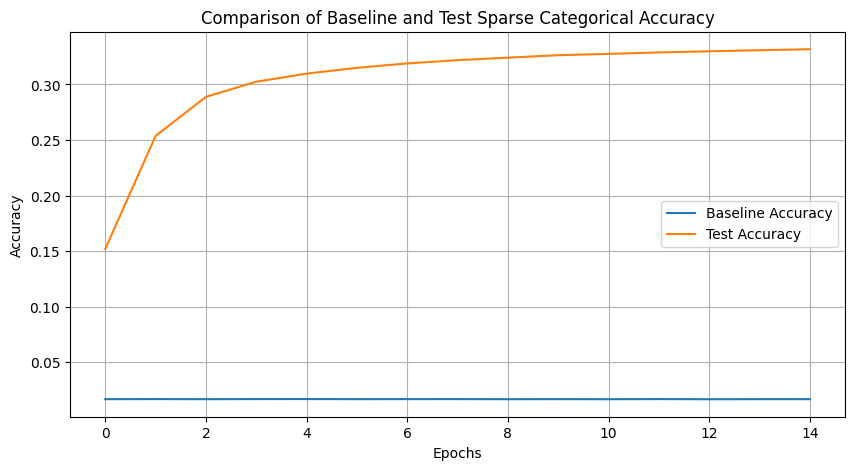

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(baseline_history.history['sparse_categorical_accuracy'], label='Baseline Accuracy')
plt.plot(test_history.history['sparse_categorical_accuracy'], label='Test Accuracy')
plt.title('Comparison of Baseline and Test Sparse Categorical Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()